In [10]:
# import libraries 
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
import pickle
from scipy.cluster import hierarchy

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch

In [11]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [12]:
#import clean data set

df_wind = pd.read_csv('../../../1_data_analysis_and_preproc/intermediate/wind/final_wind_df.csv')

In [13]:
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1,1
1,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1,1
2,11,2021-01-01 04:20:00,5.1,297.0,137.0,9.45,-3.0,10.0,1,1
3,11,2021-01-01 14:20:00,7.8,301.0,614.0,14.51,-2.0,11.0,1,1
4,11,2021-01-01 14:40:00,7.7,301.0,611.0,14.60,-2.0,10.0,1,1


wind_direction, power_average, exterior_temperature

In [14]:
df_wind = df_wind[['asset_id', 'wind_direction', 'power_average', 'exterior_temperature']]

In [15]:
np.random.seed(10)

asset = df_wind['asset_id'].unique()[0]

length = len(df_wind[df_wind['asset_id'] == asset])

subset_size = int(0.01 * length)  # Adjust the percentage as needed

# Group the DataFrame by the asset identifier column(s)
grouped = df_wind.groupby('asset_id')

# Initialize an empty list to store the sampled data
subset_data = []

# Iterate over each group, sample subset_size rows from each group, and append to subset_data
for _, group_df in grouped:
    sampled_group = group_df.sample(n=subset_size, replace=False)
    subset_data.append(sampled_group)

# Concatenate the sampled data from all groups into a single DataFrame
df_subset = pd.concat(subset_data)

In [16]:
print(f'rows per asset: {subset_size}')
print(f'subset size: {len(df_subset)}')

rows per asset: 631
subset size: 44801


In [17]:
df_subset = df_subset.reset_index(drop=True)

In [18]:
X = df_subset.loc[:, 'wind_direction':]
X = X.reset_index(drop=True)
X.head()

,wind_direction,power_average,exterior_temperature
0,217.0,340.0,16.0
1,62.0,13.0,4.0
2,-78.0,532.0,9.0
3,177.0,909.0,7.0
4,-196.0,178.0,26.0


In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

# Perform PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

pca_df.head()

,PC1,PC2
0,0.738747,-0.734238
1,-0.199476,0.074563
2,-0.311128,0.662178
3,-0.800644,-0.655436
4,1.737677,1.319443


In [20]:
pca.explained_variance_ratio_

array([0.43850959, 0.33317888])

In [21]:
loadings = pca.components_

absolute_loadings = np.abs(loadings)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

print(f'The cumulative explained variance ratio for {n_components} PCs is {cumulative_variance_ratio[-1]*100:.2f}% \n')

The cumulative explained variance ratio for 2 PCs is 77.17% 



In [22]:
pd.DataFrame(absolute_loadings, columns=['wind_direction',	'power_average',	'exterior_temperature'])

,wind_direction,power_average,exterior_temperature
0,0.092830,0.701260,0.706835
1,0.992068,0.125569,0.005712


In [23]:
pca_df = pd.read_csv('pca_df.csv')

In [24]:
pca_df.to_csv('pca_df.csv', index = False)
df_subset.to_csv('df_subset.csv', index = False)

In [25]:
# Plot dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Hierarchical clustering

## Aglomerative

### Single Link

In [26]:
# Fit Agglomerative Clustering model on the combined data
model_single = AgglomerativeClustering(linkage= 'single',distance_threshold=0.01, n_clusters=None)
model_single.fit(np.array(pca_df))

AgglomerativeClustering(distance_threshold=0.01, linkage='single',
                        n_clusters=None)

In [27]:
with open('results/hierarchical/single_clustering.pickle', 'wb') as f:
    pickle.dump(model_single, f)

In [28]:
with open('results/hierarchical/single_clustering.pickle', 'rb') as f:
    model_single = pickle.load(f)

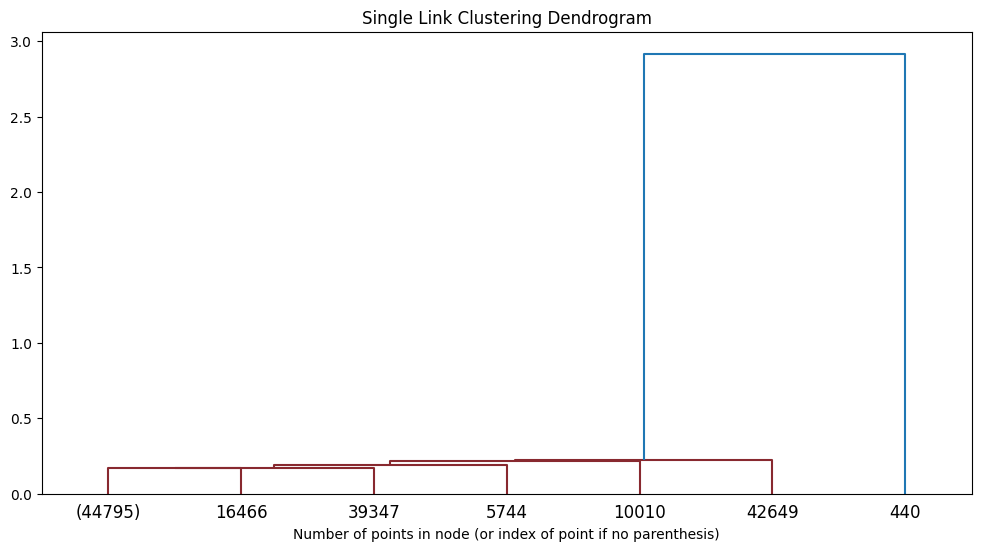

In [29]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title('Single Link Clustering Dendrogram')
# Plot the dendrogram
plot_dendrogram(model_single, truncate_mode='level', p = 5)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

In [30]:
# Cut dendrogram to obtain labels
num_clusters = 2  # Adjust as needed

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_single.children_, model_single.distances_,
                                  np.ones_like(model_single.distances_)])
# Cut the tree to obtain labels
labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

print(labels_cut)

[1 1 1 ... 1 1 1]


In [31]:
len(np.unique(labels_cut))

2

In [32]:
pca_df = pca_df.loc[:,:'PC2']

In [33]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = labels_cut
pca_df['asset_id'] = df_subset['asset_id']

In [34]:
pca_df.to_csv('results/hierarchical/csv_labels_cut_raw/single_link.csv', index = False)

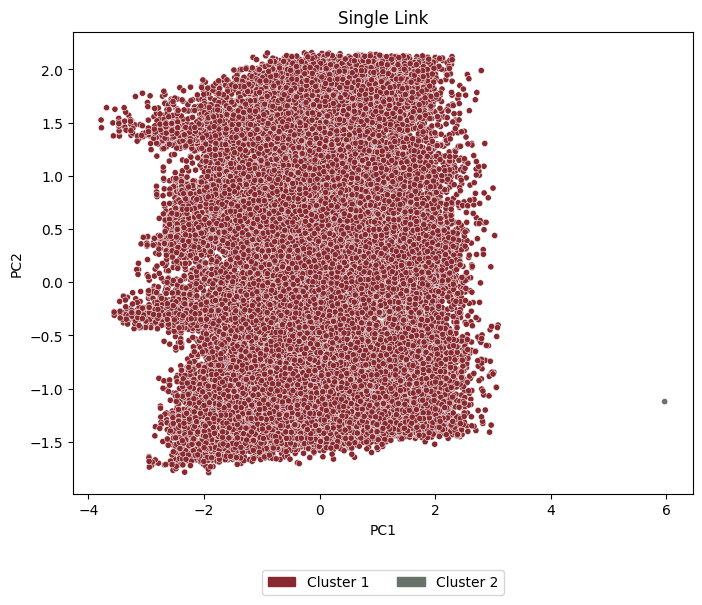

In [35]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Single Link')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [36]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns = 'cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-0.828210,-0.636266,11,1
1,0.449997,0.756881,11,1
2,1.051556,1.451060,11,1
3,-0.911238,-0.388945,11,1
4,1.337903,1.479679,11,1


In [37]:
len(most_frequent_clusters.unique())

1

In [38]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-0.828210,-0.636266,1
1,12,0.251166,0.669049,1
2,13,-1.229941,-0.226747,1
3,14,-0.713823,1.031153,1
4,15,-0.987418,1.580407,1
...,...,...,...,...
66,414,-0.870138,0.643293,1
67,415,-0.623235,1.262525,1
68,510,-1.782868,-0.200945,1
69,511,-0.132724,-1.307785,1


In [39]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


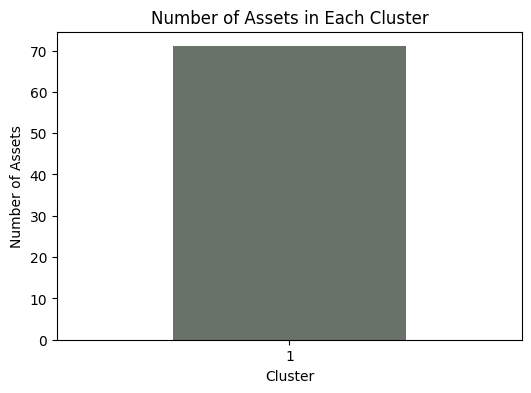

In [40]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [41]:
pca_df.to_csv('results/hierarchical/labels_most_common/single_link.csv', index= False)

In [42]:
pca_df = pca_df.loc[:,:'PC2']

### Average Link

In [43]:
model_average = AgglomerativeClustering(linkage='average', distance_threshold=0.01, n_clusters=None)
model_average.fit(np.array(pca_df))

AgglomerativeClustering(distance_threshold=0.01, linkage='average',
                        n_clusters=None)

In [44]:
average_labels = model_average.labels_

In [45]:
len(np.unique(average_labels))

29616

In [46]:
with open('results/hierarchical/average_clustering.pickle', 'wb') as f:
    pickle.dump(model_average, f)

In [104]:
with open('results/hierarchical/average_clustering.pickle', 'rb') as f:
    model_average = pickle.load(f)

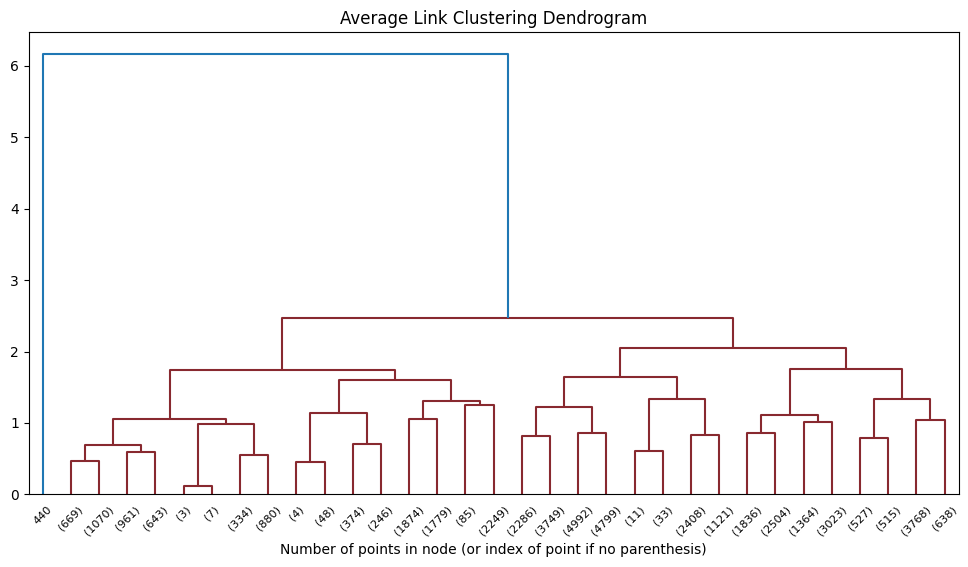

In [48]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title('Average Link Clustering Dendrogram')
# Plot the dendrogram
plot_dendrogram(model_average, truncate_mode='level', p = 5)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

In [105]:
# Cut dendrogram to obtain labels
num_clusters = 2  # Adjust as needed

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_average.children_, model_average.distances_,
                                  np.ones_like(model_average.distances_)])
# Cut the tree to obtain labels
labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

print(labels_cut)

[1 1 1 ... 1 1 1]


In [106]:
len(np.unique(labels_cut))

2

In [107]:
pca_df = pca_df[['PC1', 'PC2']]

In [108]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = labels_cut
pca_df['asset_id'] = df_subset['asset_id']

In [109]:
pca_df.to_csv('results/hierarchical/csv_labels_cut_raw/average_link.csv', index=False)

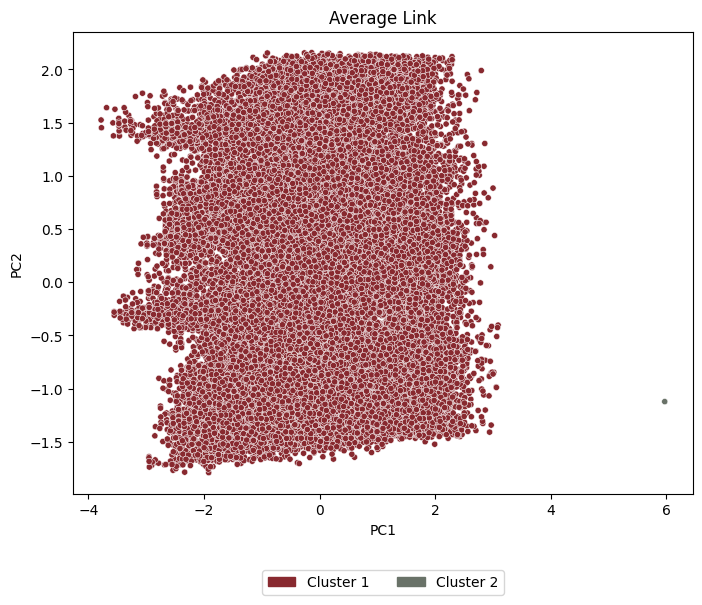

In [110]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Average Link')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [111]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-0.828210,-0.636266,11,1
1,0.449997,0.756881,11,1
2,1.051556,1.451060,11,1
3,-0.911238,-0.388945,11,1
4,1.337903,1.479679,11,1


In [112]:
len(pca_df['cluster_label'].unique())

1

In [113]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-0.828210,-0.636266,1
1,12,0.251166,0.669049,1
2,13,-1.229941,-0.226747,1
3,14,-0.713823,1.031153,1
4,15,-0.987418,1.580407,1
...,...,...,...,...
66,414,-0.870138,0.643293,1
67,415,-0.623235,1.262525,1
68,510,-1.782868,-0.200945,1
69,511,-0.132724,-1.307785,1


In [114]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


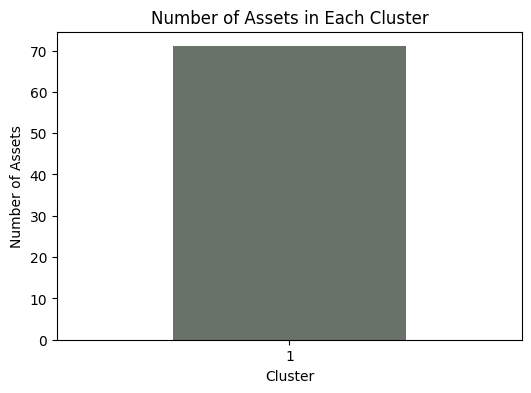

In [115]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [116]:
pca_df.to_csv('results/hierarchical/labels_most_common/average_link.csv', index=False)

In [117]:
pca_df = pca_df.loc[:,:'PC2']

### Ward's method

In [61]:
model_ward = AgglomerativeClustering(linkage='ward', distance_threshold=0.01, n_clusters=None)
model_ward.fit(np.array(pca_df))

AgglomerativeClustering(distance_threshold=0.01, n_clusters=None)

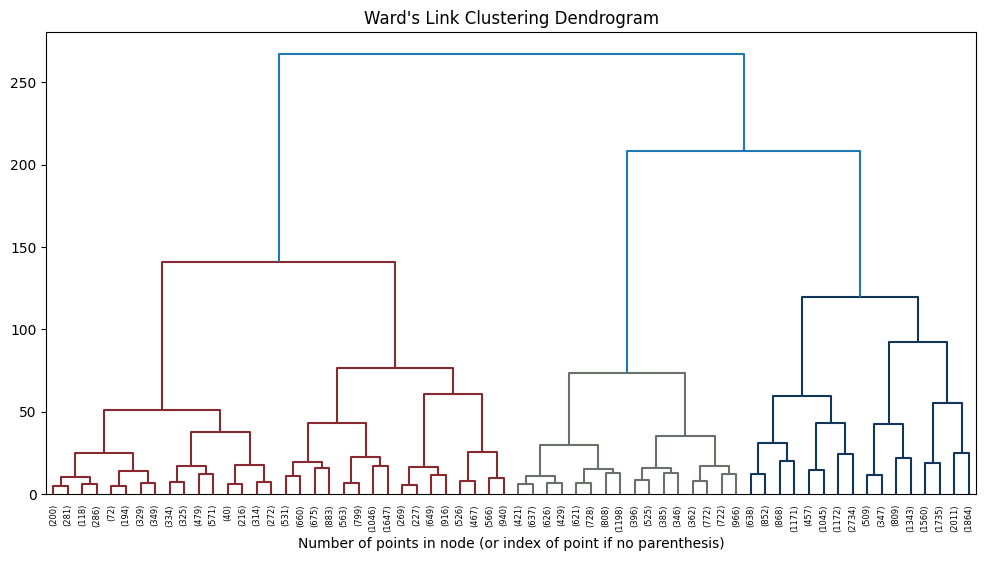

In [62]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title("Ward's Link Clustering Dendrogram")
# Plot the dendrogram
plot_dendrogram(model_ward, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

In [63]:
with open('results/hierarchical/ward_clustering.pickle', 'wb') as f:
    pickle.dump(model_ward,f)

In [64]:
with open('results/hierarchical/ward_clustering.pickle', 'rb') as f:
    model_ward = pickle.load(f)

In [65]:
# Cut dendrogram to obtain labels
num_clusters = 5  # Adjust as needed

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_ward.children_, model_ward.distances_,
                                  np.ones_like(model_ward.distances_)])
# Cut the tree to obtain labels
labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

print(labels_cut)

[2 5 5 ... 2 2 3]


In [66]:
pca_df = pca_df.loc[:,'PC1':'PC2']

In [67]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = labels_cut
pca_df['asset_id'] = df_subset['asset_id']

In [68]:
pca_df.to_csv('results/hierarchical/csv_labels_cut_raw/ward_link.csv', index=False)

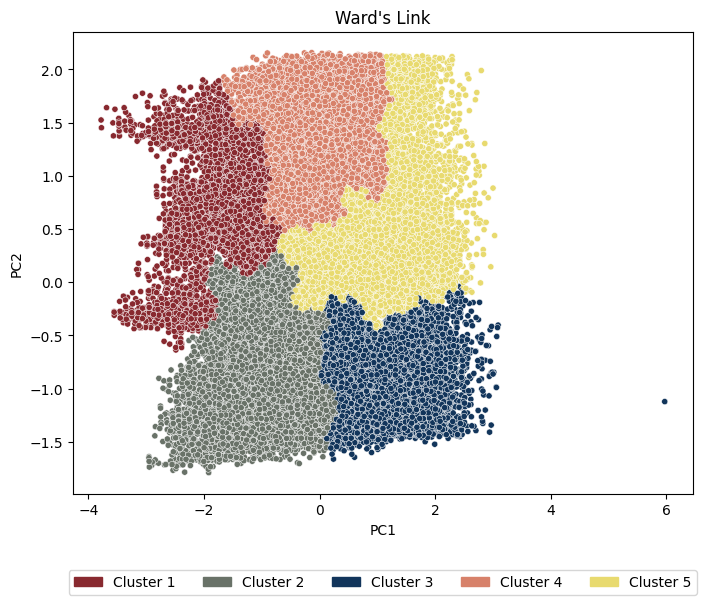

In [69]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title("Ward's Link")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut)], 
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [70]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-0.828210,-0.636266,11,5
1,0.449997,0.756881,11,5
2,1.051556,1.451060,11,5
3,-0.911238,-0.388945,11,5
4,1.337903,1.479679,11,5


In [71]:
len(most_frequent_clusters.unique())

4

In [72]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-0.828210,-0.636266,5
1,12,0.251166,0.669049,4
2,13,-1.229941,-0.226747,2
3,14,-0.713823,1.031153,2
4,15,-0.987418,1.580407,4
...,...,...,...,...
66,414,-0.870138,0.643293,4
67,415,-0.623235,1.262525,4
68,510,-1.782868,-0.200945,2
69,511,-0.132724,-1.307785,3


In [73]:
pca_df.to_csv('results/hierarchical/labels_most_common/ward_link.csv', index=False)

In [74]:
pca_df = pca_df.loc[:, :'PC2']

In [75]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 2: [2, 3, 5, 6, 7, 8, 27, 28, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 49, 50, 51, 52, 61, 68, 70]
Cluster 3: [9, 12, 22, 32, 42, 54, 65, 69]
Cluster 4: [1, 4, 16, 17, 18, 21, 23, 24, 26, 30, 33, 34, 47, 48, 55, 56, 57, 58, 64, 66, 67]
Cluster 5: [0, 10, 11, 13, 14, 15, 19, 20, 25, 29, 31, 35, 53, 59, 60, 62, 63]


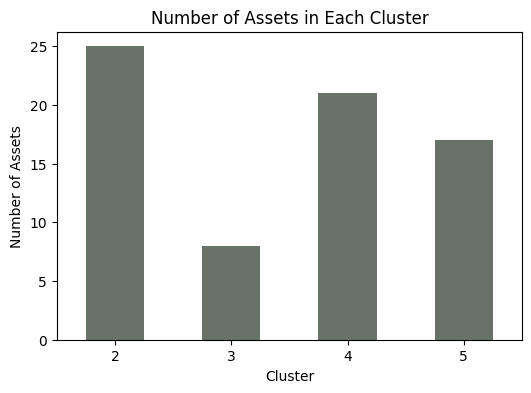

In [76]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

## Centroid Linkage

In [77]:
# Perform hierarchical clustering
model_centroid = linkage(pca_df, 'centroid')

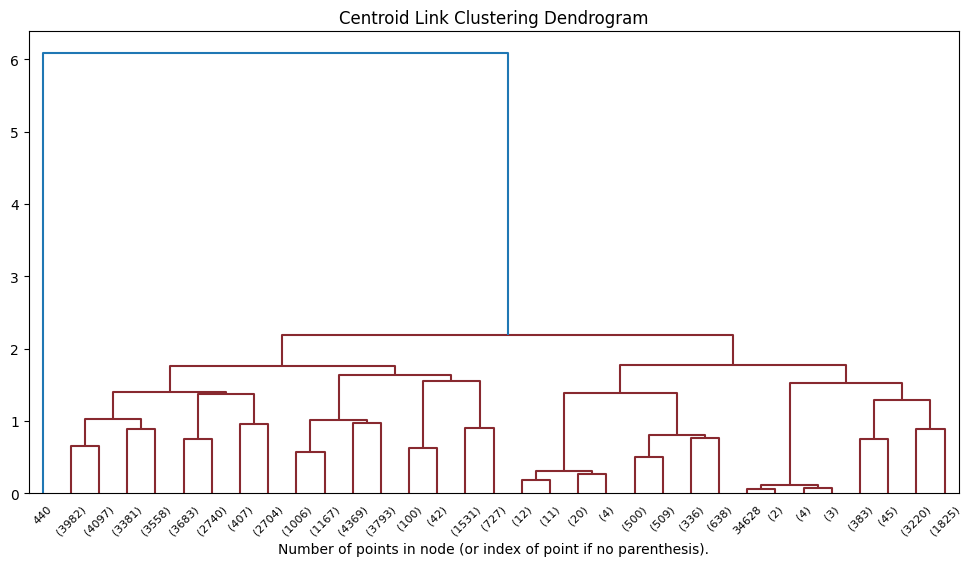

In [78]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title('Centroid Link Clustering Dendrogram')
# Plot the dendrogram
dendrogram(model_centroid, truncate_mode='level', p = 5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [79]:
with open('results/hierarchical/centroid_clustering.pickle', 'wb') as f:
    pickle.dump(model_centroid,f)

In [118]:
with open('results/hierarchical/centroid_clustering.pickle', 'rb') as f:
    model_centroid = pickle.load(f)

In [119]:
# Cut dendrogram to obtain labels
num_clusters = 2  # Adjust as needed

# Cut the tree to obtain labels
labels_cut = fcluster(model_centroid, num_clusters, criterion='maxclust')

print(labels_cut)

[1 1 1 ... 1 1 1]


In [120]:
pca_df = pca_df.loc[:,:'PC2']

In [121]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = labels_cut
pca_df['asset_id'] = df_subset['asset_id']

In [122]:
pca_df.to_csv('results/hierarchical/csv_labels_cut_raw/centroid_link.csv', index=False)

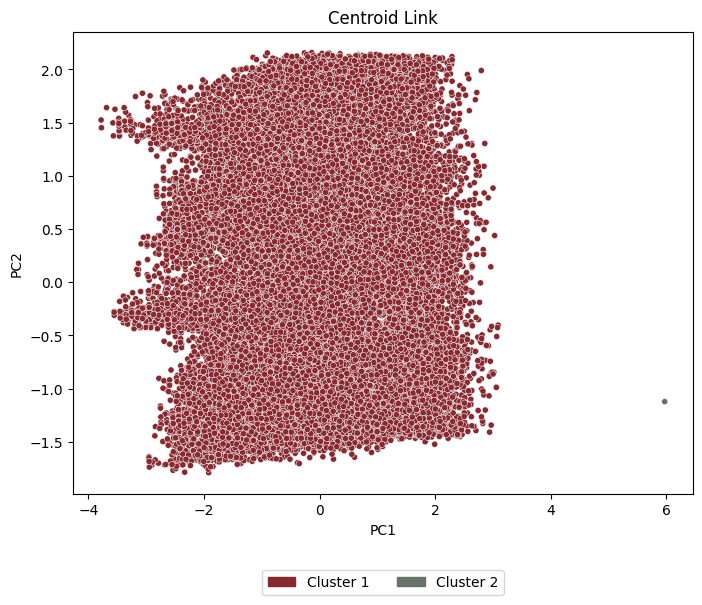

In [123]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title("Centroid Link")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [124]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-0.828210,-0.636266,11,1
1,0.449997,0.756881,11,1
2,1.051556,1.451060,11,1
3,-0.911238,-0.388945,11,1
4,1.337903,1.479679,11,1


In [125]:
len(most_frequent_clusters.unique())

1

In [126]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-0.828210,-0.636266,1
1,12,0.251166,0.669049,1
2,13,-1.229941,-0.226747,1
3,14,-0.713823,1.031153,1
4,15,-0.987418,1.580407,1
...,...,...,...,...
66,414,-0.870138,0.643293,1
67,415,-0.623235,1.262525,1
68,510,-1.782868,-0.200945,1
69,511,-0.132724,-1.307785,1


In [127]:
pca_df.to_csv('results/hierarchical/labels_most_common/centroid_link.csv', index=False)

In [128]:
pca_df = pca_df.loc[:, :'PC2']

In [129]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


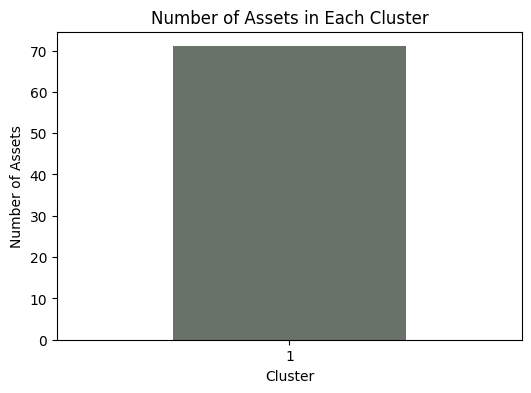

In [130]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### BIRCH

In [93]:
brc = Birch(n_clusters=None, threshold=1.5)
brc.fit(pca_df)
labels = brc.predict(pca_df)
labels

array([1, 0, 0, ..., 1, 1, 0])

In [94]:
with open('results/hierarchical/birch_clustering.pickle', 'wb') as f:
    pickle.dump(brc, f)

In [95]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']
pca_df.head()

,PC1,PC2,cluster_label,asset_id
0,-0.828210,-0.636266,1,11
1,0.449997,0.756881,0,11
2,1.051556,1.451060,0,11
3,-0.911238,-0.388945,1,11
4,1.337903,1.479679,0,11


In [96]:
pca_df.to_csv('results/hierarchical/csv_labels_cut_raw/birch.csv', index = False)

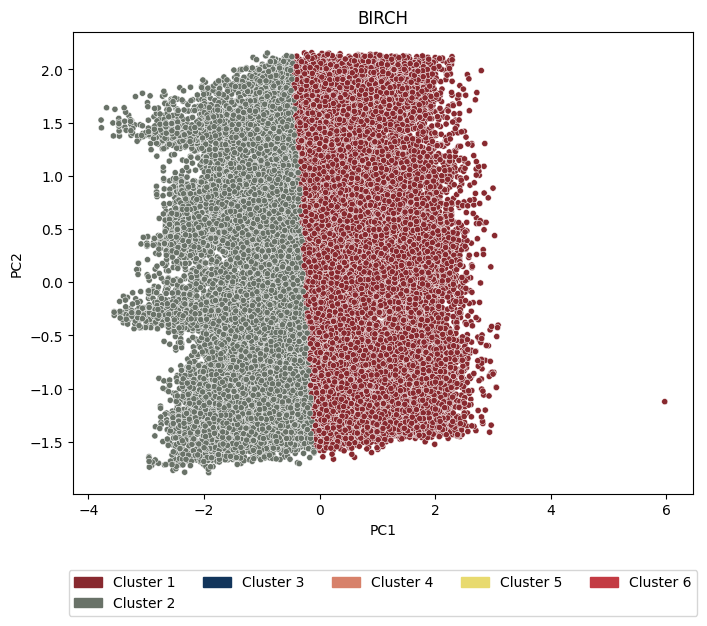

In [97]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title("BIRCH")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [98]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-0.828210,-0.636266,11,0
1,0.449997,0.756881,11,0
2,1.051556,1.451060,11,0
3,-0.911238,-0.388945,11,0
4,1.337903,1.479679,11,0


In [99]:
len(most_frequent_clusters.unique())

2

In [100]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-0.828210,-0.636266,0
1,12,0.251166,0.669049,0
2,13,-1.229941,-0.226747,0
3,14,-0.713823,1.031153,0
4,15,-0.987418,1.580407,0
...,...,...,...,...
66,414,-0.870138,0.643293,0
67,415,-0.623235,1.262525,0
68,510,-1.782868,-0.200945,0
69,511,-0.132724,-1.307785,0


In [101]:
assets_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Print assets in each cluster
for cluster, assets in assets_clusters.groupby(assets_clusters):
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [11, 12, 13, 14, 15, 16, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 110, 111, 112, 114, 115, 116, 210, 310, 311, 312, 313, 314, 315, 316, 317, 410, 411, 412, 413, 414, 415, 510, 511, 512]
Cluster 1: [17, 18, 113, 117]


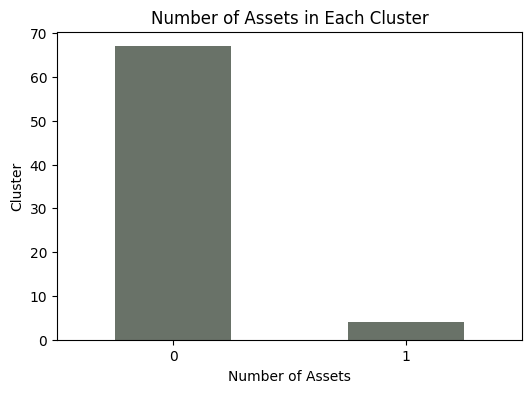

In [102]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_clusters.value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Number of Assets')
plt.ylabel('Cluster')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [103]:
pca_df.to_csv('results/hierarchical/labels_most_common/birch.csv', index = False)